## Philippine Grid Demand Analysis and Forecasting
This notebook is focused on forecasting the monthly peak demand of the Luzon, Visayas, and Mindanao grid. We will use ARIMA models to produce forecasts. The forecasts will then be used to analyze how much new renewable capacity is needed in the future based on constraints such as installed capacity requirements.
<br><br>
The monthly peak demand data used in this notebook is from NGCP: https://www.ngcp.ph/operations#operations

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (9, 4)


In [2]:
df = pd.read_csv("datasets/ph_grid_demand.csv", index_col=0, parse_dates=True, dayfirst=True)
df.tail(6)

,Luzon,Visayas,Mindanao
Date,,,
2023-01-01,9790,2058,1987
2023-02-01,10247,2085,2057
2023-03-01,11503,2248,2184
2023-04-01,12235,2417,2272
2023-05-01,12431,2458,2315
2023-06-01,12350,2389,2234


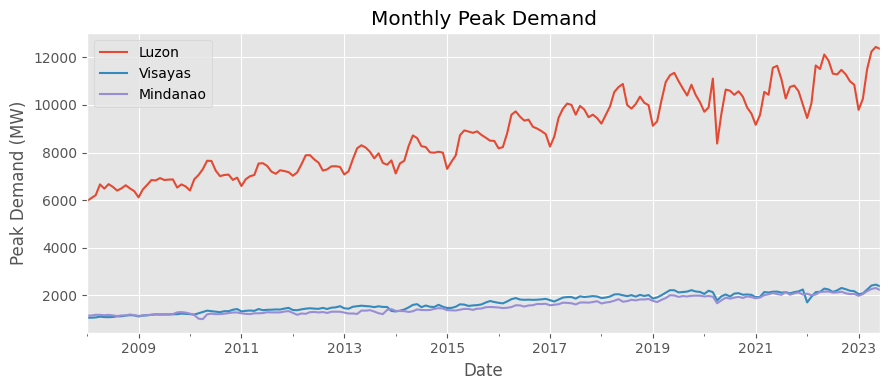

In [3]:
df.plot()
plt.ylabel("Peak Demand (MW)")
plt.title("Monthly Peak Demand")
plt.tight_layout()

We see that the peak demand for the Luzon grid dominates the peak demands from the Mindanao and Visayas grid. We see an anomaly that occured in 2020 as evidenced by the sharp drop in demand and the shift in level. This anomaly is caused by the lockdowns due to the pandemic.

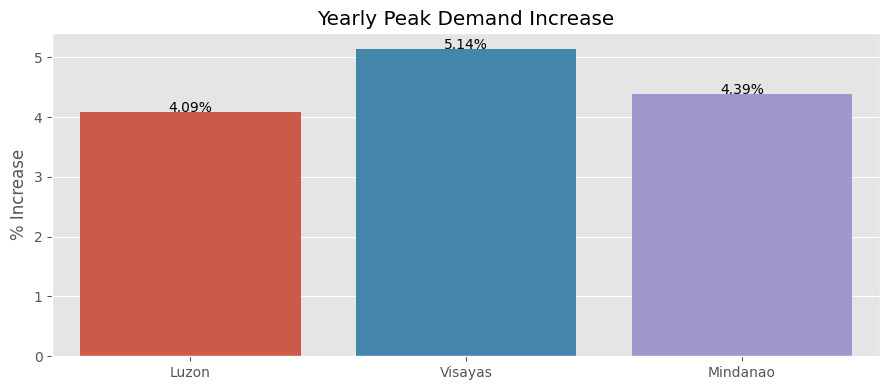

In [5]:
luzon_yearly_change = ((df.Luzon - df.Luzon.shift(12)) / df.Luzon.shift(12)).mean() * 100
visayas_yearly_change = ((df.Visayas - df.Visayas.shift(12)) / df.Visayas.shift(12)).mean() * 100
mindanao_yearly_change = ((df.Mindanao - df.Mindanao.shift(12)) / df.Mindanao.shift(12)).mean() * 100
luzon_yearly_change


yearly_change = [luzon_yearly_change, visayas_yearly_change, mindanao_yearly_change]
ax = sns.barplot(x=["Luzon", "Visayas", "Mindanao"], y=yearly_change)

for val, change in enumerate(yearly_change):
    ax.annotate("{:.2f}%".format(change), (val, change), ha="center")
    
plt.title("Yearly Peak Demand Increase")
plt.ylabel("% Increase")
plt.tight_layout()

We see that the grid with the fastest growing demand is the Visayas grid with 5.14%, whilst the Luzon and Mindanao grid have similar growth rates at 4.09% and 4.39% respectively.

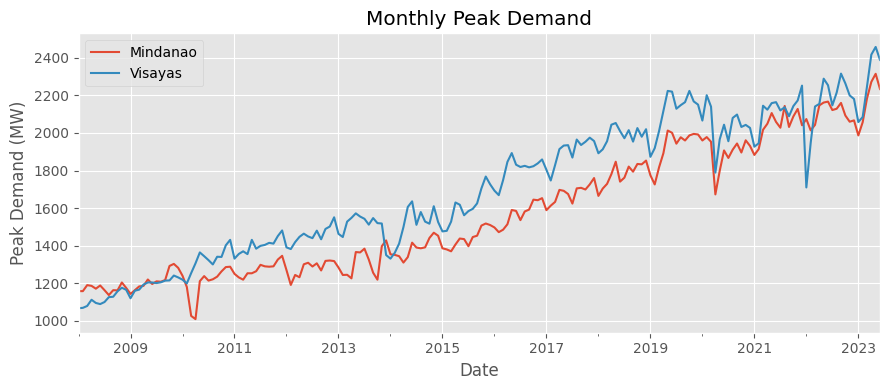

In [5]:
df[["Mindanao", "Visayas"]].plot()
plt.ylabel("Peak Demand (MW)")
plt.title("Monthly Peak Demand")
plt.tight_layout()

We see at the demand curve of the Mindanao and the Visayas grid that they are fairly in-step with each other. We also see the effects of the lockdown in the year 2020. The demand of the Mindanao grid recovered to previous level at a faster rate than the Visayas grid. A characteristic drop in demand is seen in the Visayas grid in between the year 2021 and 2022, we'll explore what happened below.

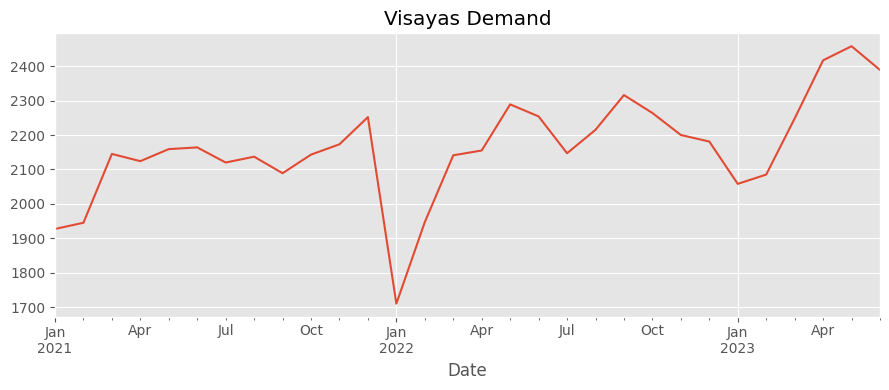

In [6]:
df.Visayas[df.index.year >= 2021].plot()
plt.title("Visayas Demand")
plt.tight_layout()

The sharp drop in demand for the month of January 2022 was probably due to typhoon Odette (Rai) which ravaged the Visayas region in the previous month. The peak demand for December 2021 was recorded before the typhoon arrived, hence its effect on demand is instead seen on the following month of January 2022.

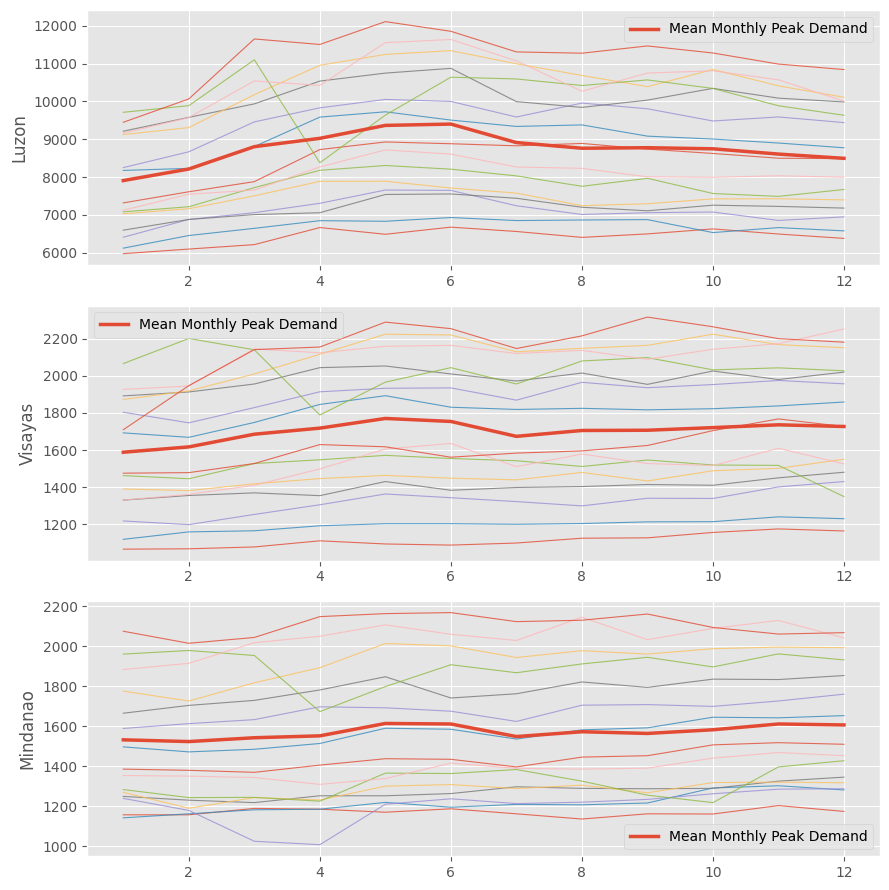

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9, 9)) 
month_idx = np.arange(12) + 1

for i, grid in enumerate(df.columns):
    for _, year in df[grid].groupby(df.index.year):
        if len(year) < 12:
            continue
        sns.lineplot(x=month_idx, y=year, ax=ax[i], alpha=0.8, linewidth=0.8)
    
    mean = df[grid].groupby(df.index.month).mean()
    
    sns.lineplot(label="Mean Monthly Peak Demand", ax=ax[i], x=month_idx, y=mean, linewidth=2.5, color="C0")
    
plt.tight_layout()        


There is a characteristic increase peak demand that occurs in the months of March to June in the Luzon grid. The same is observable for the Visayas grid, albeit at a lesser degree. The monthly peak demand for the Mindanao on the other hand is almost uniform throughout the year.

# ARIMA Modelling



In [8]:
luzon_ts = df.Luzon
luzon_ts_train = df.Luzon[df.index.year <= 2021]
luzon_ts_test = df.Luzon[df.index.year > 2021]

In [9]:
def plot_corrf(ts, lags=36):
    kpss = sm.tsa.stattools.kpss(ts)
    fig = plt.figure(figsize=(9, 5))
    
    fig.add_subplot(211)
    ts[ts.index.year > 2010].plot()
    plt.plot([], [], ' ', label="KPSS p-value: {:.3f}".format(kpss[1]))
    plt.title("Series")
    plt.legend()
 
    fig.add_subplot(223)
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=plt.gca())
    
    fig.add_subplot(224)
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=plt.gca(), method="ywm")
    
    plt.tight_layout()

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


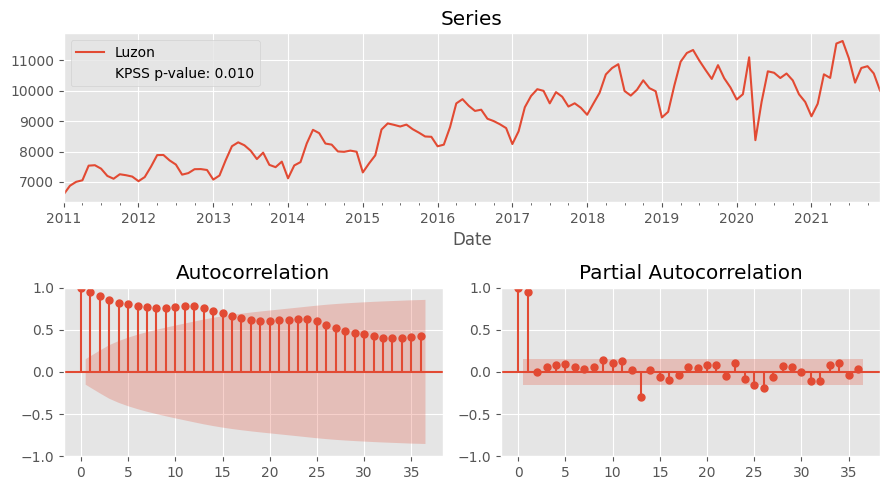

In [10]:
plot_corrf(luzon_ts_train)

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


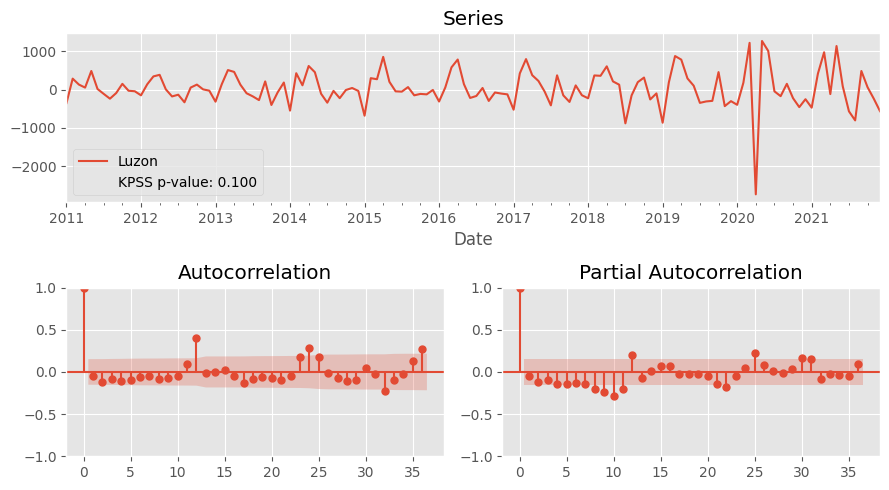

In [11]:
from statsmodels.tsa.statespace.tools import diff

diff_01_00 = diff(luzon_ts_train, k_diff=1, k_seasonal_diff=0, seasonal_periods=12)
plot_corrf(diff_01_00)

The KPSS returns a non-significant result, which means that an order of differencing by 1 makes the series stationary. <br>
The autocorrelation function plot hints an MA(0) and a seasonal MA(3) model. <BR>
The partial autocorrelation function plot hints at an AR(1) and a seasonal AR(2)

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


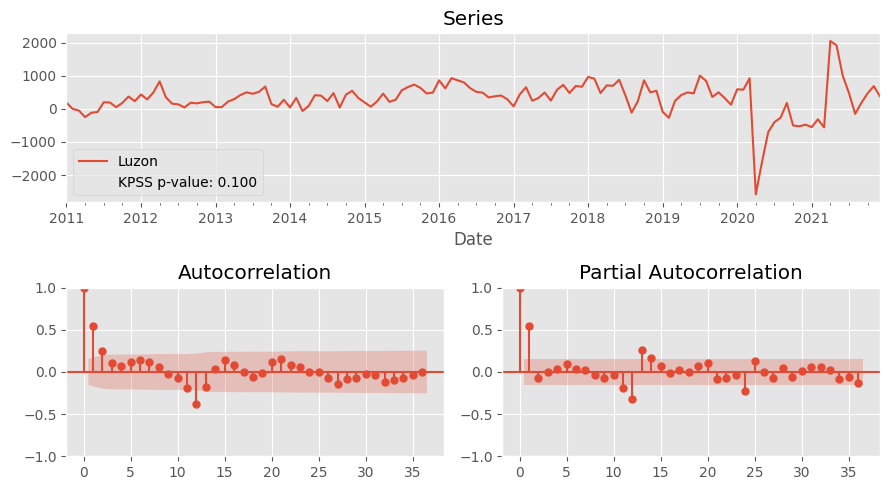

In [12]:
diff_00_01 = diff(luzon_ts_train, k_diff=0, k_seasonal_diff=1, seasonal_periods=12)
plot_corrf(diff_00_01)

Seasonaly differencing also produces a stationary series based on the KPSS test. <br>
The acf plot hints at an MA(2) and a seasonal MA(1) model. <br>
The pacf plot hints at an AR(1) and a seasonal AR(2) model 

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


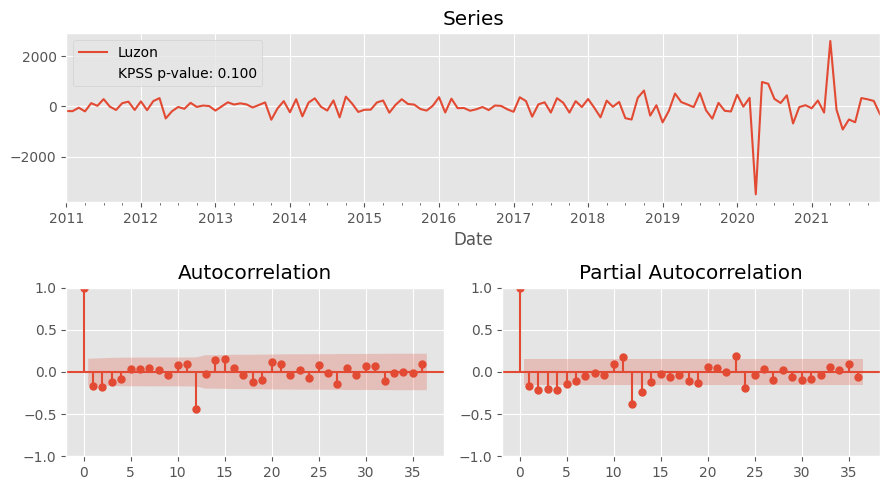

In [13]:
diff_01_01 = diff(luzon_ts_train, k_diff=1, k_seasonal_diff=1, seasonal_periods=12)
plot_corrf(diff_01_01)

Performing both first order first differences and seasonal differences, we again have a non-significant kpss test p-value. <br>
We get an MA(2) and a seasonal MA(1) model from the acf plot. <br>
We get an AR(4) and a seasonal AR(2) model from the pacf plot.

In [14]:
def train_arima(orders, seasonal_orders, ts, log_transform=False):
    if log_transform:
        ts = np.log(ts)
    
    #generate changepoint variable
    exog = pd.Series(np.zeros(len(ts)), index=ts.index)
    exog[exog.index >= "2020-03-01"] = 1
    
    aicc = []
    bic = []
    idx_ = []
    diff_n = []
    for order, seasonal_order in zip(orders, seasonal_orders):
        model = sm.tsa.arima.ARIMA(ts, exog=exog,
                                    order=order,
                                    seasonal_order=seasonal_order).fit()
        aicc.append(model.aicc)
        bic.append(model.bic)
        idx_.append(str(order)+str(seasonal_order))
        diff_n.append(order[1] + seasonal_order[1])
    
    df_res = pd.DataFrame()
    
    df_res["AICC"] = aicc
    df_res["BIC"] = bic
    df_res["degree_diff"] = diff_n
    df_res.index =idx_
    
    return df_res
                     
    

In [15]:
#test all possible models we generated from looking at the acf and pacf plots

first = [(0,1,0), (1,1,0), (0,0,2), (1,0,0), (0,1,2), (4,1,0)]
seasonal = [(3,0,0,12), (2,0,0,12), (0,1,1,12), (2,1,0,12)]

first_x = []
second_x = []

for f in first:
    for s in seasonal:
        first_x.append(f)
        second_x.append(s)

In [16]:
%%time
import warnings

warnings.filterwarnings('ignore')
corf_res = train_arima(first_x, second_x, luzon_ts_train, log_transform=True)
warnings.filterwarnings('default')

CPU times: total: 2.86 s
Wall time: 28.2 s


In [17]:
dfs = [df for df in corf_res.groupby("degree_diff")]
dfs[1][1].sort_values(by="AICC").head()

,AICC,BIC,degree_diff
"(0, 1, 2)(3, 0, 0, 12)",-631.704888,-610.583334,1
"(0, 1, 2)(2, 0, 0, 12)",-623.731297,-605.548334,1
"(4, 1, 0)(3, 0, 0, 12)",-614.641773,-587.726326,1
"(4, 1, 0)(2, 0, 0, 12)",-608.601393,-584.568835,1
"(1, 1, 0)(3, 0, 0, 12)",-603.297514,-585.114551,1


We see that for the models with only first differencing with degree 1, the best model is an MA(2) with a seasonal AR(3) model

In [18]:
dfs[2][1].sort_values(by="AICC").head()

,AICC,BIC,degree_diff
"(0, 1, 2)(0, 1, 1, 12)",-595.519235,-580.704794,2
"(0, 1, 2)(2, 1, 0, 12)",-592.609977,-574.916994,2
"(4, 1, 0)(0, 1, 1, 12)",-577.627103,-557.085032,2
"(4, 1, 0)(2, 1, 0, 12)",-574.795175,-551.434076,2
"(1, 1, 0)(0, 1, 1, 12)",-558.617732,-546.710699,2


For the models with first differencing and a degree 1 seasonal differencing, we see that the best model with the lowest AICC is the (0,1,2)(0,1,1,12) model.

417.7019842231761

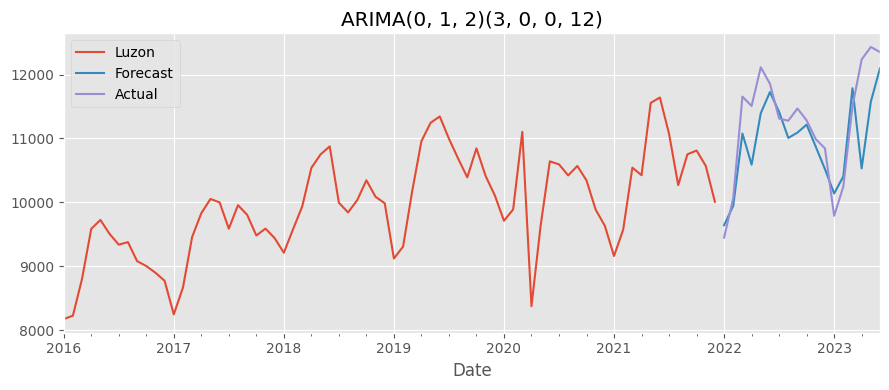

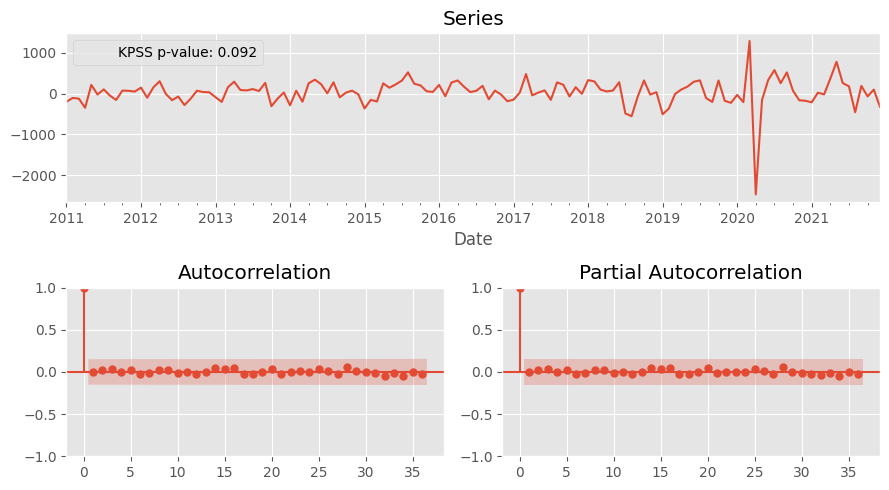

In [19]:
from sklearn.metrics import mean_absolute_error as mae

warnings.filterwarnings('ignore')


def train_plot_test(ts, test, order, seasonal_order, log_transform=False, mae_only=False):
    if log_transform:
        ts = np.log(ts)
    
    exog = pd.Series(np.zeros(len(ts)), index=ts.index)
    exog[exog.index >= "2020-03-01"] = 1
    
    exog_fore = pd.Series(np.ones(len(test)), index=test.index)
    
    model = sm.tsa.arima.ARIMA(ts,
                               exog=exog,
                               order=order,
                               seasonal_order=seasonal_order).fit()
    preds = model.predict()
    fore = model.forecast(steps=len(test), exog=exog_fore)
    
    if log_transform:
        fore = np.e ** fore
        ts = np.e ** ts
        preds = np.e ** preds
        
    if not mae_only:
        ts[ts.index.year > 2015].plot()
        fore.plot(label="Forecast")
        test.plot(label="Actual")
        plt.title("ARIMA{order}{seasonal_order}".format(order=order, seasonal_order=seasonal_order))
        plt.legend()
        plt.tight_layout()
        
        resid = ts - preds
        plot_corrf(resid)
        plt.tight_layout()

        
    return mae(test, fore)
    
train_plot_test(luzon_ts_train, luzon_ts_test,
               order=(0,1,2),
               seasonal_order=(3,0,0,12),
               log_transform=True)



The acf and pacf plots looks great, though the KPSS p-value could be better.

269.51401255884633

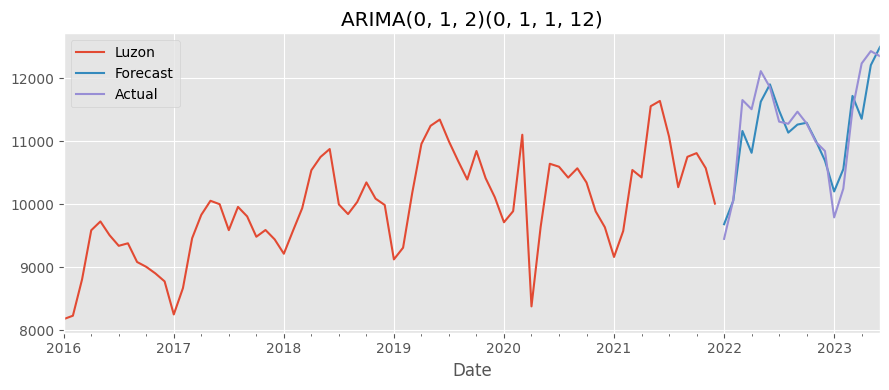

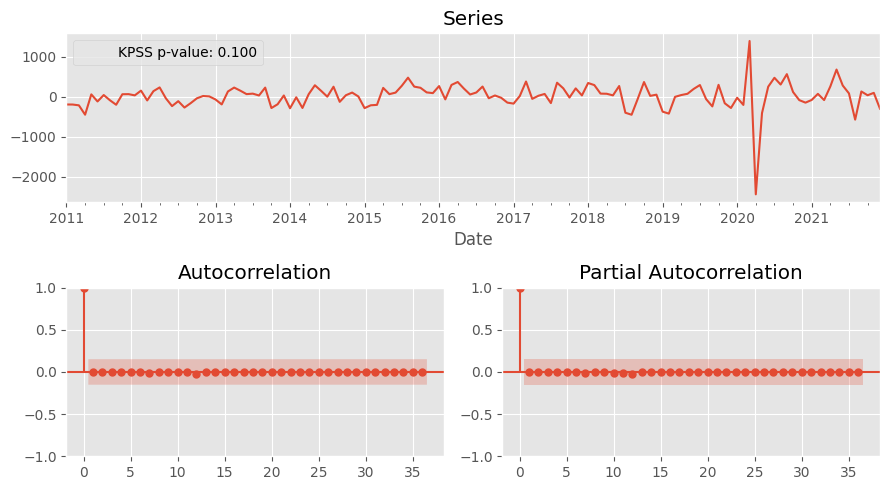

In [20]:
train_plot_test(luzon_ts_train, luzon_ts_test,
               order=(0,1,2),
               seasonal_order=(0,1,1,12),
               log_transform=True)


The ARIMA(0,1,2)(0,1,1,12) seems to perform the best basing on the MAE on the test set with only an average error of 269 MW. <br>
The acf and pacf plots on the residuals look great and we have confidence on the results of the kpss p-value. The residual plot also looks stationary by eye. Overall a great result.

108.57519713911617

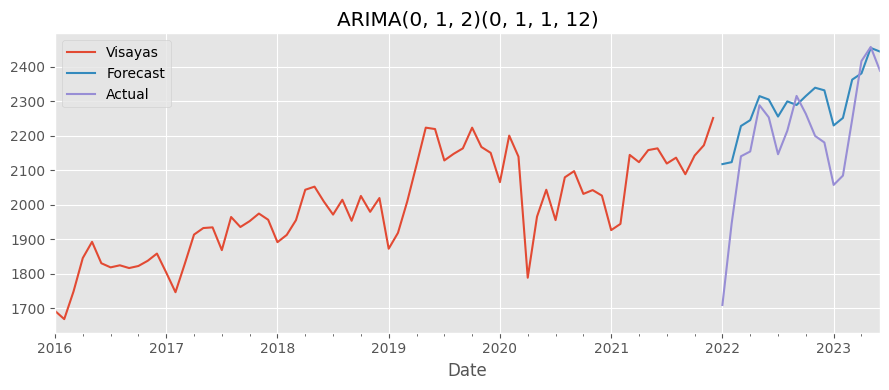

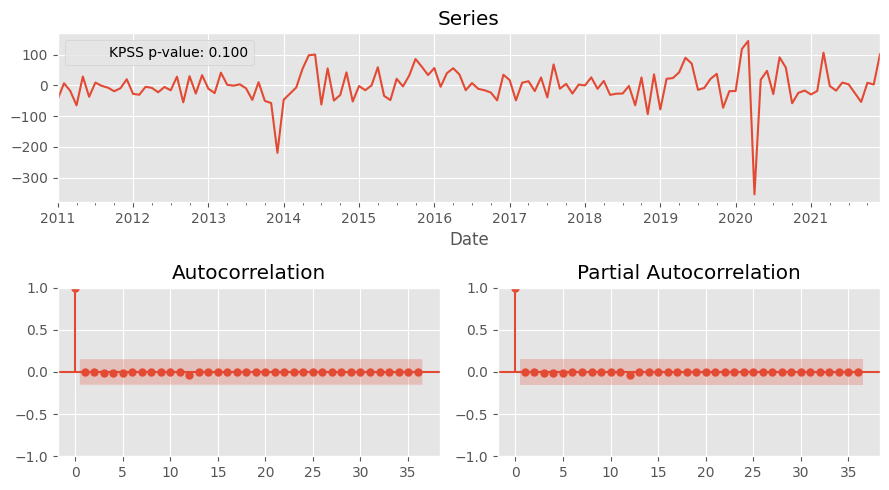

In [21]:
visayas_train_ts = df.Visayas[df.index.year <= 2021]
visayas_test_ts = df.Visayas[df.index.year > 2021]

train_plot_test(visayas_train_ts, visayas_test_ts,
               order=(0,1,2),
               seasonal_order=(0,1,1,12),
               log_transform=True)

We see that the same model is perfectly usable for the Visayas grid with only an average error rate of 108 MW.

60.750611800597454

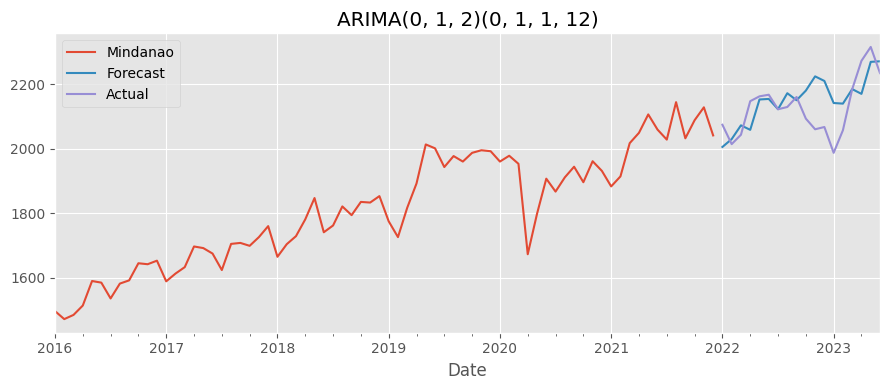

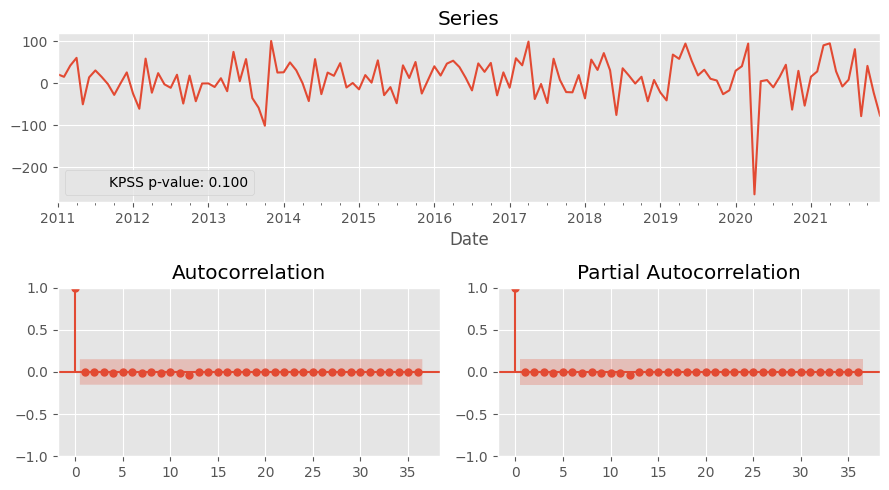

In [23]:
mindanao_train_ts = df.Mindanao[df.index.year <= 2021]
mindanao_test_ts = df.Mindanao[df.index.year > 2021]

train_plot_test(mindanao_train_ts, mindanao_test_ts,
               order=(0,1,2),
               seasonal_order=(0,1,1,12),
               log_transform=True)

In [22]:
exog = pd.Series(np.zeros(len(luzon_ts_train)), index=luzon_ts_train.index)
exog[exog.index >= "2020-03-01"] = 1

model_sum = sm.tsa.arima.ARIMA(np.log(luzon_ts_train), exog,
                              order=(0,1,2),
                              seasonal_order=(0,1,1,12)).fit()
model_sum.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Luzon   No. Observations:                  168
Model:             ARIMA(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 302.961
Date:                            Mon, 21 Aug 2023   AIC                           -595.922
Time:                                    20:47:09   BIC                           -580.705
Sample:                                01-01-2008   HQIC                          -589.741
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0958      0.007    -12.822      0.000      -0.110      -0.081
ma.L1         -0.7140      0.075     -9.518      0.000      -0.861      -0.567
ma.L2         -0.1767      0.079     -2.246      0.025      -0.331      -0.022
ma.S.L12      -0.6956      0.114     -6.120      0.000      -0.918      -0.473
sigma2         0.0011   8.58e-05     12.830      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3438.14
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                            -2.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The same model returns great result for the Mindanao grid. So we can use the same model to forecast each of the 3 grids and aggregate them to get the Philippine grid forecast.

### Using AutoARIMA


In [32]:
from pmdarima.arima import auto_arima

autoarima = auto_arima(np.log(luzon_ts_train), exog=exog,
                      start_p=0,
                      start_q=2,
                      start_P=0,
                      start_Q=1,
                      seasonal=True,
                      m=12)


In [33]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 319.208
Date:                              Mon, 21 Aug 2023   AIC                           -626.416
Time:                                      20:55:16   BIC                           -607.708
Sample:                                  01-01-2008   HQIC                          -618.822
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4246      0.172     -2.473      0.013      -0.761      -0.088
ma.L2         -0.2286      0.132     -1.730      0.084      -0.488       0.030
ma.L3         -0.1188      0.138     -0.858      0.391      -0.390       0.152
ar.S.L12       0.9532      0.043     22.090      0.000       0.869       1.038
ma.S.L12      -0.6785      0.124     -5.477      0.000      -0.921      -0.436
sigma2         0.0012   7.09e-05     16.812      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14279.68
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               4.68   Skew:                            -4.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

319.9375912599053

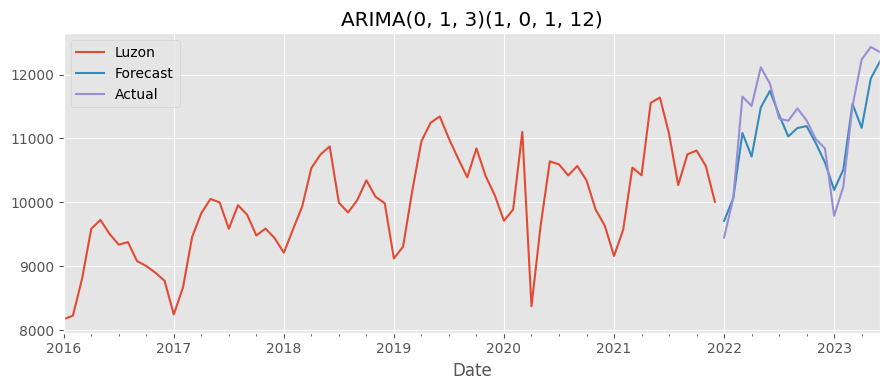

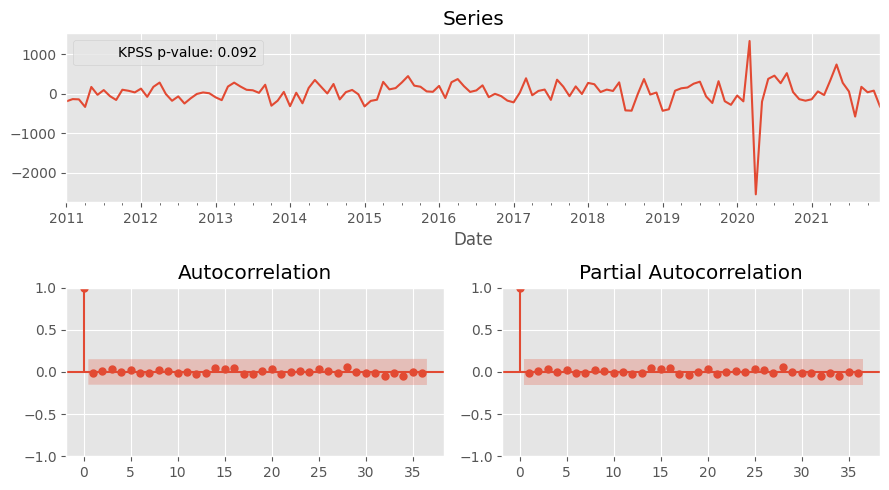

In [36]:
train_plot_test(luzon_ts_train, luzon_ts_test,
               order=(0,1,3),
               seasonal_order=(1,0,1,12),
               log_transform=True)

64.65720264960301

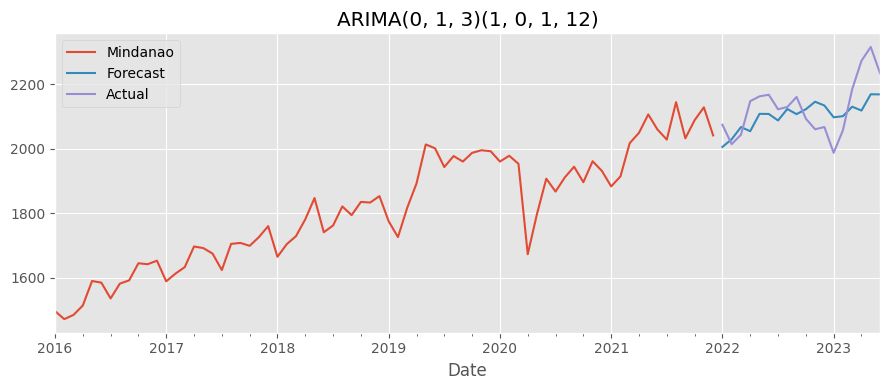

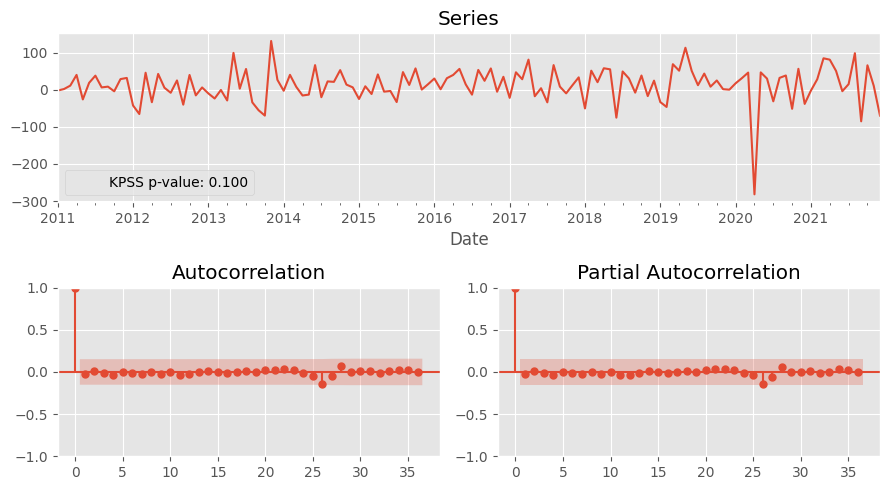

In [39]:
train_plot_test(mindanao_train_ts, mindanao_test_ts,
               order=(0,1,3),
               seasonal_order=(1,0,1,12),
               log_transform=True)

103.75565551614096

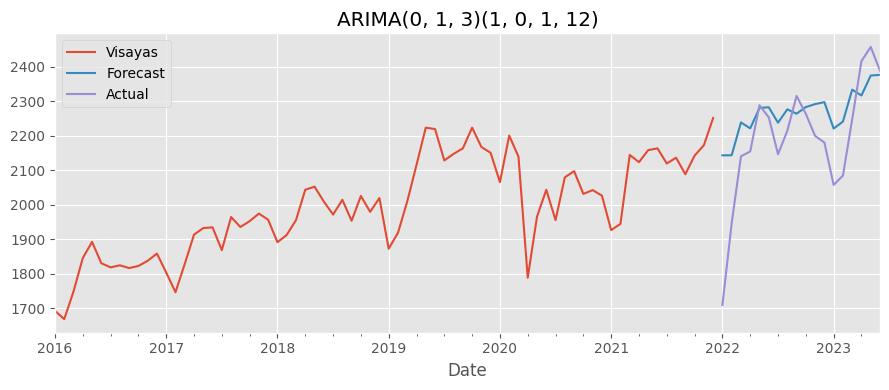

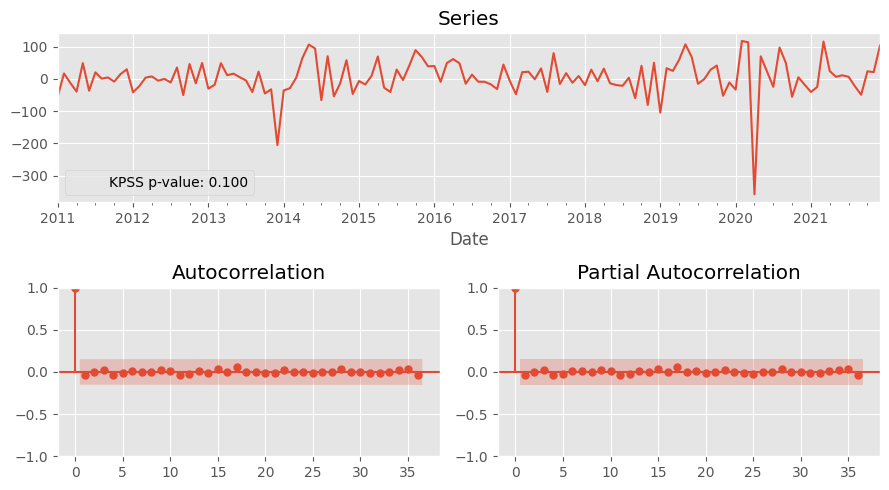

In [40]:
train_plot_test(visayas_train_ts, visayas_test_ts,
               order=(0,1,3),
               seasonal_order=(1,0,1,12),
               log_transform=True)

#### Discussion of AutoARIMA

The auto-ARIMA function yielded a model of ARIMA(0,1,3)(1,0,1,12). When compared to our first choice model, which is ARIMA(0,1,2)(0,1,1,2), our first model performs a little bit better on the test set and is a simpler model. Hence we decide to use the first model that we've found.

## Forecasting

In [103]:

class ForecastDemand():
    
    def __init__(self, log_transform=True):
        
        self.y = None
        self.exog = None
        self.log_transform = log_transform
        self.models = {"Luzon": None,
                      "Visayas": None,
                      "Mindanao": None}
    
    def fit(self, y, order=(0,1,2), seasonal_order=(0,1,1,12)):
        if self.log_transform:
            y = np.log(y)
        self.y = y
            
        pandemic_changepoint = pd.Series(np.zeros(len(y)), index=y.index)
        pandemic_changepoint[y.index >= "2020-03-01"] = 1
        
        
        for grid in ["Luzon", "Visayas", "Mindanao"]:
            self.models[grid] = sm.tsa.arima.ARIMA(y[grid],
                                                  exog=pandemic_changepoint,
                                                  order=order,
                                                  seasonal_order=seasonal_order).fit()
        
        return self
    
    def predict(self, steps=36):  
        idx_ = pd.date_range(start=self.y.index[-1], freq="MS", periods=steps+1)[1:]
        pandemic_changepoint = pd.Series(np.ones(steps), index=idx_)
        
        df_preds = pd.DataFrame(index=idx_)
        
        for grid in self.models:
            forecast = self.models[grid].forecast(exog=pandemic_changepoint, steps=steps)
            df_preds[grid] = forecast
        
        if self.log_transform:
            df_preds = np.e ** df_preds
        
        df_preds["Total"] = df_preds[df_preds.columns[0]] + df_preds[df_preds.columns[1]] + df_preds[df_preds.columns[2]]
        
        return df_preds

In [104]:
model_final = ForecastDemand(log_transform=False).fit(df)
forecasts = model_final.predict(42)

In [105]:
df["Total"] = df.Mindanao + df.Visayas + df.Luzon

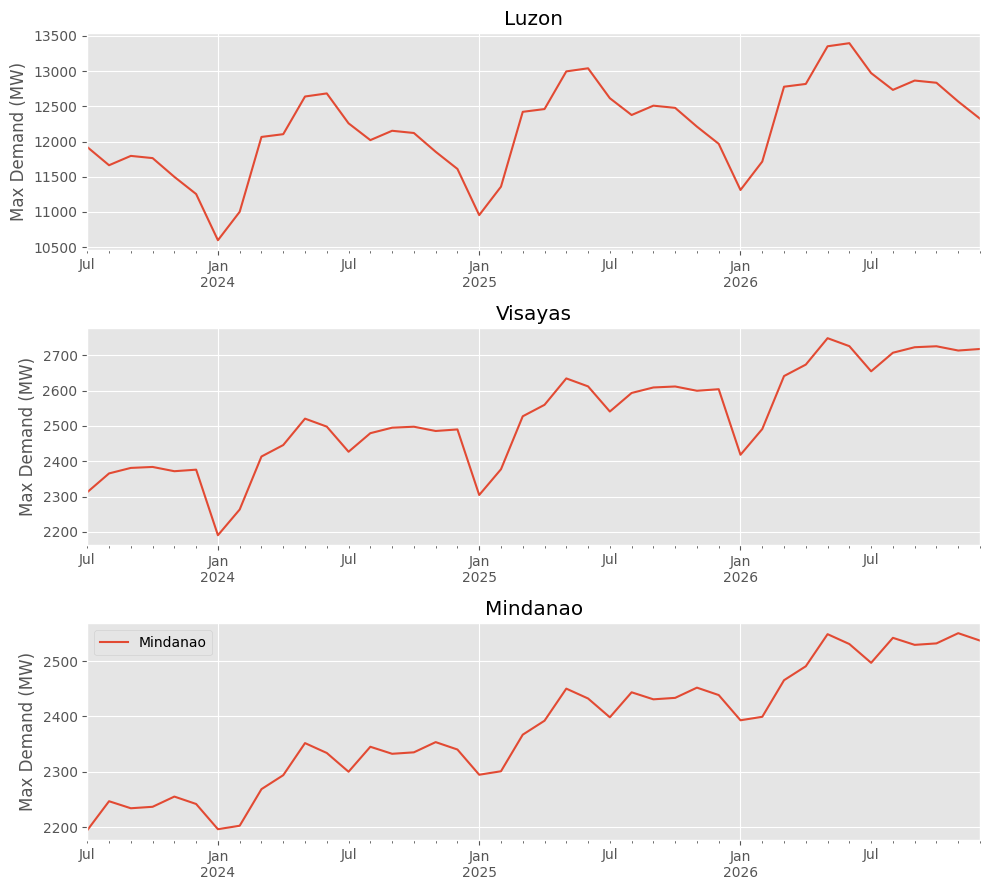

In [106]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))
for i, forecast in enumerate(forecasts.columns[:-1]):
    forecasts[forecast].plot(ax=ax[i])
    ax[i].set_title(forecast)
    ax[i].set_ylabel("Max Demand (MW)")
    
plt.tight_layout()
plt.legend()

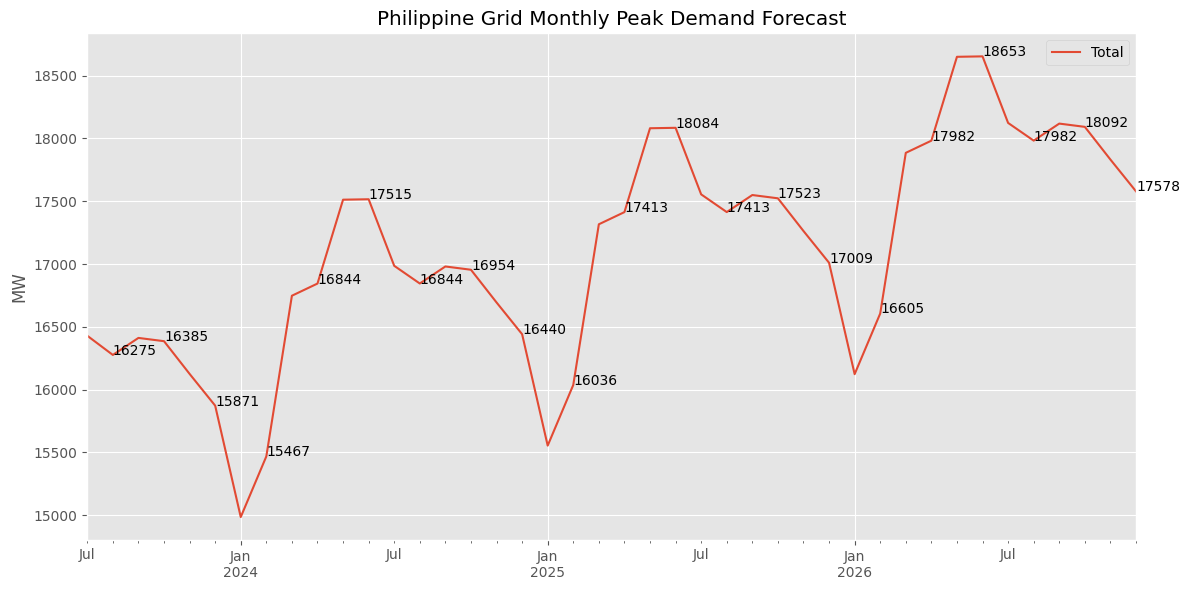

In [166]:
fig = plt.figure(figsize=(12, 6))
forecasts.Total.plot()

steps = 1
for idx, forecast in zip(forecasts.index, forecasts.Total):
    if forecast is np.nan:
        continue
    if steps % 2 == 0:
        plt.annotate(int(forecast), (idx, forecast))
    steps += 1
    
plt.ylabel("MW")
plt.title("Philippine Grid Monthly Peak Demand Forecast")
plt.legend()
plt.tight_layout()


## Installed Capacity of the Philippine Grids

### Luzon

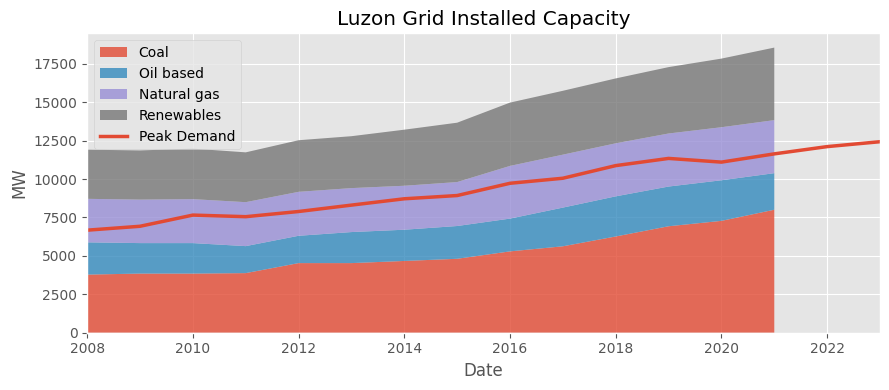

In [92]:
luzon_capacity = pd.read_csv("datasets/luzon_installed_capacity.csv", index_col=0)
plt.stackplot(luzon_capacity.index,
             luzon_capacity.coal,
             luzon_capacity.oil_based,
             luzon_capacity.natural_gas,
             luzon_capacity.renewable,
             labels=["Coal", "Oil based", "Natural gas", "Renewables"],
             alpha=0.8)

luzon_yearly_max = df.Luzon.groupby(df.index.year).max()
luzon_yearly_max.plot(label="Peak Demand", linewidth=2.5, color="C0")

plt.title("Luzon Grid Installed Capacity")
plt.legend()
plt.xlim(2008, 2023)
plt.ylabel("MW")
plt.tight_layout()

1.5625121157557413

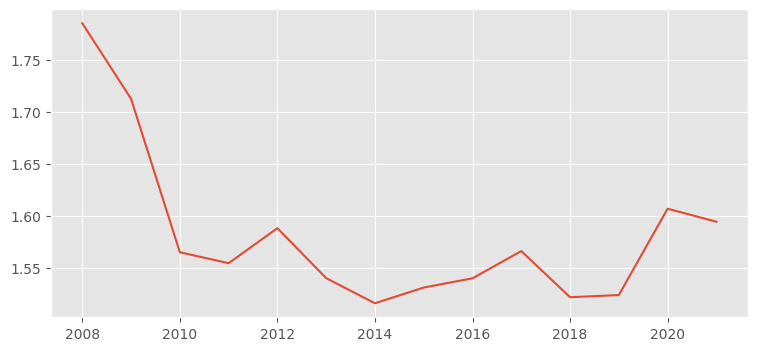

In [168]:
reserve_ratio = luzon_capacity.sum(axis=1)[luzon_capacity.index >= 2008] / df.Luzon.groupby(df.index.year).max()[:-2]
reserve_ratio.plot()
reserve_ratio[-5:].mean()

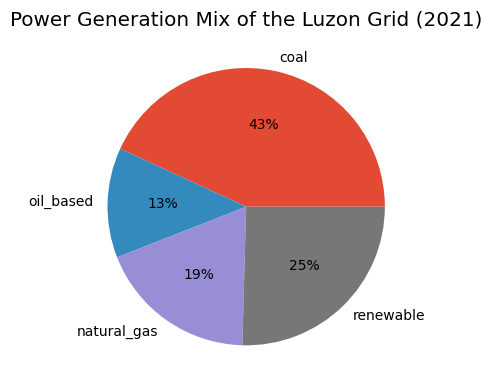

In [140]:
power_mix = (luzon_capacity.iloc[-1] / luzon_capacity.iloc[-1].sum())
plt.pie(power_mix, labels=power_mix.index, autopct='%.0f%%')
plt.title("Power Generation Mix of the Luzon Grid (2021)")
plt.tight_layout()

In [145]:
peak_yearly_luzon_forecast = forecasts.Luzon.groupby(forecasts.index.year).max()
luzon_25margin = (peak_yearly_luzon_forecast * 1.5)
pd.DataFrame([peak_yearly_luzon_forecast, luzon_25margin], index=["Peak Demand", "50% Margin Installed Capacity"])

,2023,2024,2025,2026
Peak Demand,11921.205273,12683.385261,13040.295644,13397.206026
50% Margin Installed Capacity,17881.807910,19025.077892,19560.443466,20095.809040


In [170]:
luzon_capacity

,coal,oil_based,natural_gas,renewable
2003,3769,2514,2763,2765
2004,3769,2514,2763,3115
2005,3769,2404,2763,3192
2006,3769,2333,2763,3226
2007,3783,2363,2834,3194
2008,3783,2100,2831,3199
2009,3849,1984,2831,3199
2010,3849,1984,2861,3287
2011,3879,1757,2861,3242
2012,4531,1778,2861,3358


#### Discussion
A large portion of the power generated in the Luzon grid comes from coal at a share of 43% of the total installed capacity, renewable sources such as solar and hydro accounts for a quarter of the installed capacity. If the construction of fossil fuel burning power plants is to be stopped after 2021, then it would require an additional 1000 MW of capacity* from renewable sources to be available in 2025 in order to maintain the capacity to peak demand ratio of 1.5.

<br><br>
*from 2021 levels

### Visayas

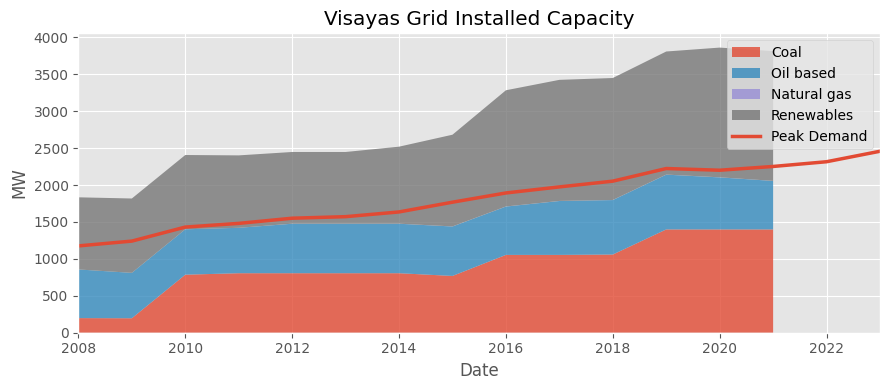

In [159]:
visayas_capacity = pd.read_csv("datasets/visayas_installed_capacity.csv", index_col=0)
plt.stackplot(visayas_capacity.index,
             visayas_capacity.coal,
             visayas_capacity.oil_based,
             visayas_capacity.natural_gas,
             visayas_capacity.renewables,
             labels=["Coal", "Oil based", "Natural gas", "Renewables"],
             alpha=0.8)

visayas_yearly_max = df.Visayas.groupby(df.index.year).max()
visayas_yearly_max.plot(label="Peak Demand", linewidth=2.5, color="C0")

plt.title("Visayas Grid Installed Capacity")
plt.legend()
plt.xlim(2008, 2023)
plt.ylabel("MW")
plt.tight_layout()

1.715117467524447

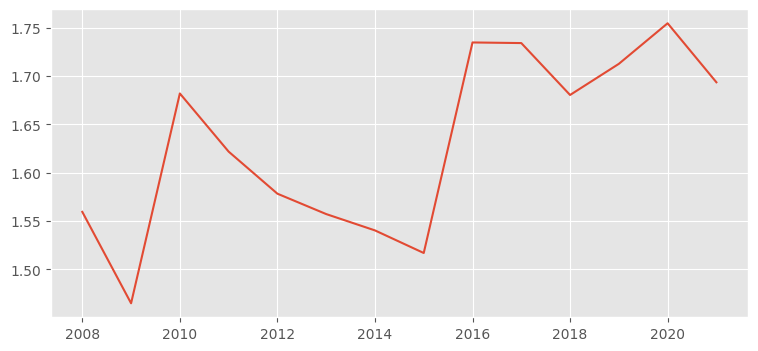

In [169]:
reserve_ratio = visayas_capacity.sum(axis=1)[visayas_capacity.index >= 2008] / df.Visayas.groupby(df.index.year).max()[:-2]
reserve_ratio.plot()
reserve_ratio[-5:].mean()

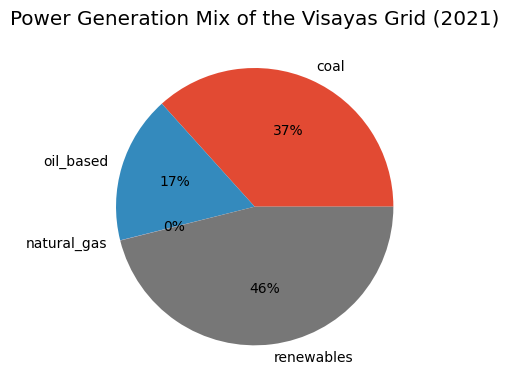

In [162]:
power_mix = (visayas_capacity.iloc[-1] / visayas_capacity.iloc[-1].sum())
plt.pie(power_mix, labels=power_mix.index, autopct='%.0f%%')
plt.title("Power Generation Mix of the Visayas Grid (2021)")
plt.tight_layout()

In [175]:
peak_yearly_visayas_forecast = forecasts.Visayas.groupby(forecasts.index.year).max()
visayas_margin = (peak_yearly_visayas_forecast * 1.5)
pd.DataFrame([peak_yearly_visayas_forecast, visayas_margin], index=["Peak Demand", "50% Margin Installed Capacity"])

,2023,2024,2025,2026
Peak Demand,2384.0090,2520.802174,2634.716299,2748.630423
50% Margin Installed Capacity,3576.0135,3781.203261,3952.074448,4122.945634


In [164]:
visayas_capacity

,coal,oil_based,natural_gas,renewables
2003,189,530,0,927
2004,198,596,0,927
2005,198,668,0,927
2006,198,678,0,927
2007,198,659,0,976
2008,198,659,0,977
2009,196,615,0,1007
2010,786,615,0,1006
2011,806,615,0,981
2012,806,670,1,971


#### Discussion
46% of the installed capacity in the Visayas grid is in the form of renewable energy, significantly larger in proportion compared to the Luzon renewable energy shares. Coal accounts for 37% of the installed capacity in the region whilst oil-based plants account for the remaining 17%. Maintaining a 1.5 capacity to peak demand ratio, the Visayas grid only requires 138 MW of additional renewable capacity by 2025*.
<br><br>
*from 2021 levels.

## Mindanao

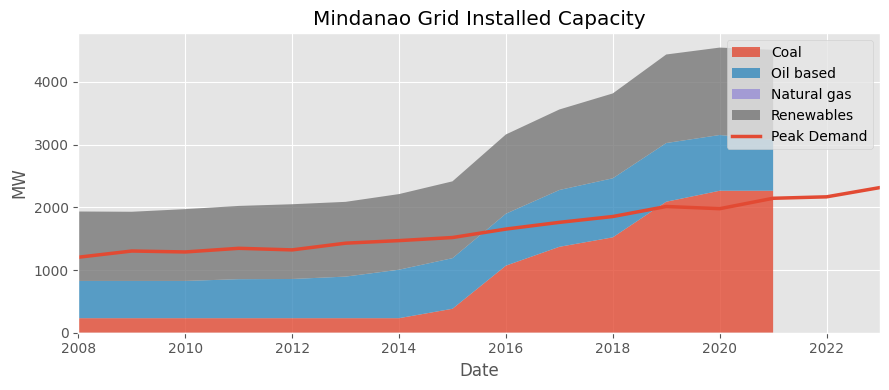

In [171]:
mindanao_capacity = pd.read_csv("datasets/mindanao_installed_capacity.csv", index_col=0)
plt.stackplot(mindanao_capacity.index,
             mindanao_capacity.coal,
             mindanao_capacity.oil_based,
             mindanao_capacity.natural_gas,
             mindanao_capacity.renewables,
             labels=["Coal", "Oil based", "Natural gas", "Renewables"],
             alpha=0.8)

mindanao_yearly_max = df.Mindanao.groupby(df.index.year).max()
mindanao_yearly_max.plot(label="Peak Demand", linewidth=2.5, color="C0")

plt.title("Mindanao Grid Installed Capacity")
plt.legend()
plt.xlim(2008, 2023)
plt.ylabel("MW")
plt.tight_layout()

2.137812238213079

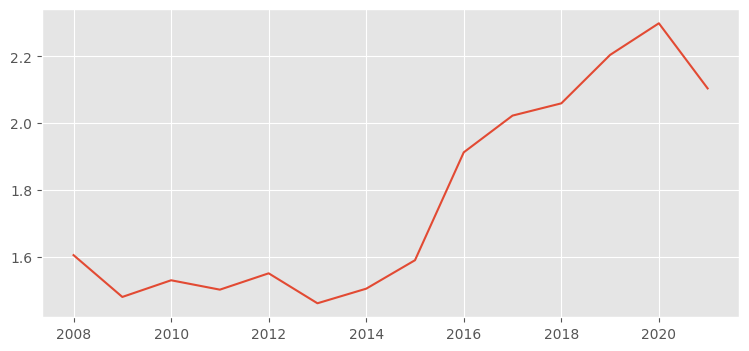

In [172]:
reserve_ratio = mindanao_capacity.sum(axis=1)[mindanao_capacity.index >= 2008] / df.Mindanao.groupby(df.index.year).max()[:-2]
reserve_ratio.plot()
reserve_ratio[-5:].mean()

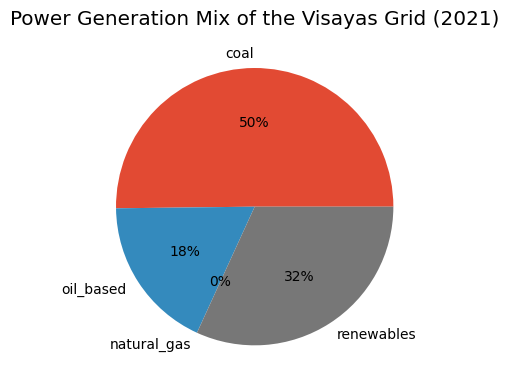

In [173]:
power_mix = (mindanao_capacity.iloc[-1] / mindanao_capacity.iloc[-1].sum())
plt.pie(power_mix, labels=power_mix.index, autopct='%.0f%%')
plt.title("Power Generation Mix of the Visayas Grid (2021)")
plt.tight_layout()

In [174]:
peak_yearly_mindanao_forecast = forecasts.Mindanao.groupby(forecasts.index.year).max()
mindanao_margin = (peak_yearly_visayas_forecast * 1.5)
pd.DataFrame([peak_yearly_mindanao_forecast, mindanao_margin], index=["Peak Demand", "50% Margin Installed Capacity"])

,2023,2024,2025,2026
Peak Demand,2255.52236,2353.752417,2451.982474,2550.212531
50% Margin Installed Capacity,3576.01350,3781.203261,3952.074448,4122.945634


In [177]:
mindanao_capacity

,coal,oil_based,natural_gas,renewables
2003,0,559,0,1106
2004,0,559,0,1106
2005,0,591,0,1107
2006,210,591,0,1107
2007,232,594,0,1107
2008,232,594,0,1107
2009,232,594,0,1103
2010,232,594,0,1145
2011,232,622,0,1168
2012,232,625,0,1192


Coal accounts for 50% of the installed capacity in the Mindanao grid, followed by renewables and oil-based plants with 32% and 18% of the share respectively. There is a surplus of capacity in the Mindanao grid as seen at their installed capacity to peak demand ratio plots above. The peak demand forecast in 2025 is low enough that the grid does not necessitate an increase in capacity in order to have a capacity to peak demand ratio of 1.5.

## Conclusion

By 2025, our forecasts show that the Philippine grid will have a peak demand of 18000 MW. Assuming that the Philippines stops building coal, gas, and oil-based plants, the grid will need an additional 1138 MW of renewable energy capacity from its 2021 levels if the installed capacity to peak demand ratio is to be kept at 1.5. <br><br>

The renewable capacity required, in real world conditions, is probably much higher than 1138 MW. The actual dependable capacity from the installed capacity of each grid is actually much lower due to various conditions such as the physical state of the power plants and weather conditions. Additional capacity in the form of renewables also increases volatility to the grid. This is due to the weather and time dependence of popular renewable energy sources, mainly solar and wind. The effect is that a much larger capacity than the actual forecasted capacity is needed in order to ensure grid stability.